In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" #"1"
os.chdir("/nas/ucb/oliveradk/diverse-gen/")

In [2]:
import json
from functools import partial
from itertools import product
from typing import Optional, Literal, Callable
from tqdm import tqdm
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from collections import defaultdict

import submitit
from submitit.core.utils import CommandFunction
import nevergrad as ng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

from losses.loss_types import LossType
from utils.exp_utils import get_executor, get_executor_local, run_experiments
from utils.utils import conf_to_args

In [3]:
SCRIPT_NAME = "measurement_tampering.py"
EXP_DIR = Path("output/mtd_exps") # output/mtd_exps
EXP_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
seeds = list(range(8))
method_configs = {
    # TopK
    # "TopK 0.1": {"loss_type": LossType.TOPK, "mix_rate_schedule": "linear", "mix_rate_t0": 0},
    # "DivDis": {"loss_type": LossType.DIVDIS},
    "FT Trusted": {"loss_type": LossType.ERM, "aux_weight": 0.0, "heads": 1}, # Model
    # "Probe for Evidence of Tamper": {
    #     "loss_type": LossType.ERM,  "aux_weight": 0.0, 
    #     "heads": 1, "source_labels": ["sensors_agree"], "split_source_target": False, 
    #     "target_only_disagree": True, "freeze_model": True, "lr": 2e-4},
    "Measurement Predictor (baseline)": {
        "loss_type": LossType.ERM, "heads": 1, "train": False, "load_prior_probe": True
    }
}

dataset_configs = {
    "diamonds": {
        "dataset": f"diamonds", 
        "model": f"codegen-350M-mono-measurement_pred-diamonds", 
        "bootstrap_eval": False, 
        "frac_warmup_steps": 0.10, # 64 step, 
        "epochs": 5, 
        "mix_rate_t1": 1
    },
   "generated-stories": {
        "dataset": "generated_stories", 
        "model": "pythia-1_4b-deduped-measurement_pred-generated_stories", 
        "bootstrap_eval": False,
        "micro_batch_size": 2, 
        "max_length": 1536, 
        "feature_dim": 2048, 
        "frac_warmup_steps": 0.15, # 8 steps, 
        "epochs": 4, 
        "mix_rate_t1": 1
   }
}
# TODO: update
dataset_method_hparam_map = {
    "diamonds": {
        "TopK 0.1": {"lr": 2e-5, "aux_weight": 1.0},
        "DivDis": {"lr": 2e-5, "aux_weight": 3.0},
        "FT Trusted": {"lr": 2e-5},
        "Probe for Evidence of Tamper": {"lr": 2e-4},
    },
    "generated-stories": {
        "TopK 0.1": {"lr": 3e-6, "aux_weight": 2.5},
        "DivDis": {"lr": 3e-6, "aux_weight": 3.0},
        "FT Trusted": {"lr": 5e-3},
        "Probe for Evidence of Tamper": {"lr": 5e-4},
    }
}

configs = {}
for (ds_name, ds_config), (method_name, method_config), seed in product(dataset_configs.items(), method_configs.items(), seeds):
    configs[(ds_name, method_name, seed)] = {
        **ds_config, 
        **method_config, 
        "seed": seed, 
        **dataset_method_hparam_map[ds_name].get(method_name, {})
    } 
    if ds_name == "diamonds":
        configs[(ds_name, method_name, seed)]["dataset"] += f"-seed{seed}"
        configs[(ds_name, method_name, seed)]["model"] += f"-seed{seed}"

def get_conf_dir(conf_name: tuple):
    ds, method, seed = conf_name
    return f"{EXP_DIR}/{ds}_{method}/{seed}"

for conf_name, conf in configs.items():
    conf["exp_dir"] = get_conf_dir(conf_name)


# Run Experiments

In [14]:
# executor = get_executor_local(EXP_DIR)
# jobs = run_experiments(executor, list(configs.values())[:1], SCRIPT_NAME)

In [5]:
non_80gb_nodes = ["ddpg", "dqn", "gail", "gan","ppo", "vae"]
slurm_exclude = ",".join([f"{node}.ist.berkeley.edu" for node in non_80gb_nodes])
executor = get_executor(EXP_DIR, mem_gb=32, slurm_exclude=slurm_exclude)
jobs = run_experiments(executor, list(configs.values()), SCRIPT_NAME)

# Process Results

In [17]:
from typing import Literal
from pathlib import Path
def get_exp_metrics(conf: dict):
    if not (Path(conf["exp_dir"]) / "metrics.json").exists():
        raise FileNotFoundError(f"Metrics file not found for experiment {conf['exp_dir']}")
    with open(Path(conf["exp_dir"]) / "metrics.json", "r") as f:
        exp_metrics = json.load(f)
    return exp_metrics

def get_max_acc(
    exp_metrics: dict,
    acc_metric: Literal["test_acc", "test_worst_acc", "test_acc_alt"]="test_acc",
    model_selection: Literal["acc", "loss", "weighted_loss", "repulsion_loss"]="acc",
    head_1_epochs: Optional[int] = None,
    single_head: bool = False
):
    if head_1_epochs is not None:
        exp_metrics = {k: v[head_1_epochs:] for k, v in exp_metrics.items()}
    max_accs = np.array(exp_metrics[f'{acc_metric}_0'])
    if not single_head:
        max_accs = np.maximum(max_accs, np.array(exp_metrics[f'{acc_metric}_1']))
    if model_selection == "acc": 
        max_acc_idx= np.argmax(max_accs)
    elif model_selection == "loss":
        max_acc_idx = np.argmin(exp_metrics["val_loss"])
    elif model_selection == "weighted_loss":
        max_acc_idx = np.argmin(exp_metrics["val_weighted_loss"])
    elif model_selection == "repulsion_loss":
        max_acc_idx = np.argmin(exp_metrics["target_val_weighted_repulsion_loss"])
    else: 
        raise ValueError(f"Invalid model selection: {model_selection}")
    max_acc = max_accs[max_acc_idx]
    return max_acc

# data structure: dictionary with keys method types, values dict[mix_rate, list[len(seeds)]] of cifar accuracies (for now ignore case where mix_rate != mix_rate_lower_bound)
def get_acc_results(
    exp_configs: list[dict],
    acc_metric: Literal["test_acc", "test_worst_acc", "test_acc_alt"]="test_acc",
    model_selection: Literal["acc", "loss", "weighted_loss", "repulsion_loss"]="acc",
    verbose: bool=False, 
    single_head: bool = False
):
    results = []
    for conf in exp_configs:
        try:
            exp_metrics = get_exp_metrics(conf)
            head_1_epochs = round(conf["epochs"] / 2) if conf["loss_type"] == LossType.DBAT else None
            max_acc = get_max_acc(exp_metrics, acc_metric, model_selection, head_1_epochs, single_head)
            results.append(max_acc)
        except FileNotFoundError:
            if verbose:
                print(f"Metrics file not found for experiment {conf['exp_dir']}")
            continue
    return results

In [18]:
exps_by_dataset_method = defaultdict(lambda: defaultdict(list))
for (ds_name, method_name, seed), conf in configs.items():
    exps_by_dataset_method[ds_name][method_name].append(conf)

results_by_dataset_method = defaultdict(dict[list])
for ds_name, method_dict in exps_by_dataset_method.items():
    for method_name, exps in method_dict.items():
        results_by_dataset_method[ds_name][method_name] = get_acc_results(
            exps, acc_metric="epoch_test_auroc", model_selection="loss", 
            single_head=(method_name not in ["TopK 0.1", "DivDis"])
        )


In [19]:
results_by_dataset_method

defaultdict(dict[list],
            {'diamonds': {'TopK 0.1': [0.9836741071428571,
               0.9510042091836735,
               0.9671760841836735,
               0.9906330357142857,
               0.9881081632653063,
               0.9570645408163265,
               0.9631392857142858,
               0.9819632015306122],
              'DivDis': [0.7770677295918367,
               0.9772642857142858,
               0.7987515306122448,
               0.9509094387755102,
               0.9278422831632653,
               0.9006128826530613,
               0.941027232142857,
               0.9128241709183673],
              'Probe for Evidence of Tamper': [0.9806376275510205,
               0.9856204081632653,
               0.9736228316326532,
               0.9882520408163264,
               0.9887100765306123,
               0.9829848214285714,
               0.9852987244897959,
               0.9899906887755102]},
             'generated-stories': {'TopK 0.1': [0.9291044776119403,

In [20]:
def plot_method_comparison(results_dict, title=None):
    # Calculate statistics
    method_stats = {}
    for method, values in results_dict.items():
        method_stats[method] = {
            'mean': np.mean(values),
            'std': np.std(values)
        }
    
    # Prepare plot data
    methods = list(method_stats.keys())
    means = [method_stats[m]['mean'] for m in methods]
    stds = [method_stats[m]['std'] for m in methods]
    
    # Create plot
    plt.figure(figsize=(10, 6))
    
    # Plot bars with error bars
    bars = plt.bar(methods, means, yerr=stds, capsize=5)
    
    # Customize plot
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.ylabel('AUROC')
    if title:
        plt.title(title)
    
    # Rotate x-axis labels if they're long
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gca()

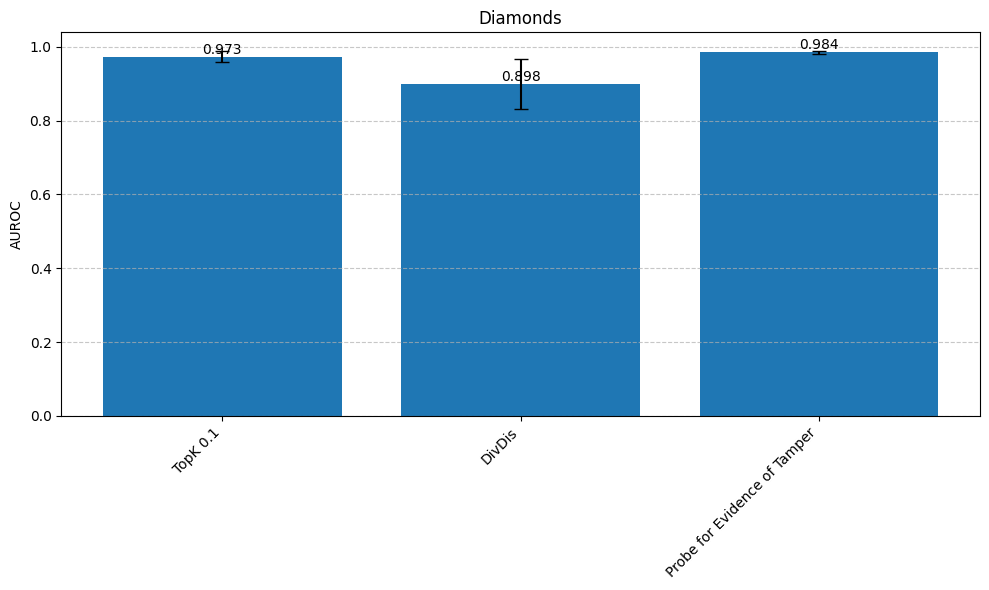

In [21]:
plot_method_comparison(results_by_dataset_method["diamonds"], "Diamonds")
plt.show()

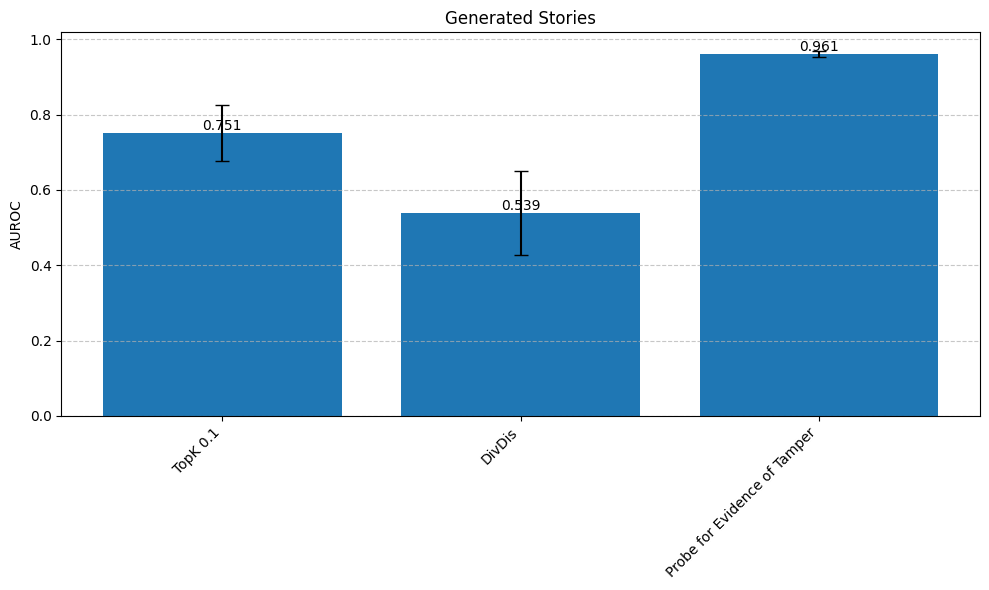

In [22]:
plot_method_comparison(results_by_dataset_method["generated-stories"], "Generated Stories")
plt.show()